# Imports

In [120]:
import face_recognition
import numpy as np
from elasticsearch import Elasticsearch
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image

# Make Connection with EalsticSearch

In [70]:
# Create an Elasticsearch client instance
es = Elasticsearch(
    hosts=['http://127.0.0.1:9200'],
    verify_certs = False
)
es.ping()

True

In [105]:
# Index name where faces will be stored
INDEX_NAME = "faces"


mappings = {
    "properties": {
      "image_id": {
        "type": "keyword"
      },
      "image_path": {
        "type": "keyword"
      },
      "image_features": {
        "type": "dense_vector",
        "dims": 128
      }
    }
}

# Ensure that the index exists, or create it
if not es.indices.exists(index=INDEX_NAME):
    es.indices.create(index=INDEX_NAME,mappings=mappings)

In [107]:
# es.indices.delete(index='faces')

In [108]:
# Function to retrieve face encoding using face_recognition
def get_face_encoding(image):
    # Find face locations and encodings in the image
    face_locations = face_recognition.face_locations(image)
    face_encodings = face_recognition.face_encodings(image, face_locations)
    
    if len(face_encodings) > 0:
        return face_encodings[0]  # Return the encoding of the first face found
    else:
        return None

In [109]:
# Function to encode the face and store it in Elasticsearch
def index_face(image_path, person_id):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Use face_recognition to find faces and extract embeddings
    face_encoding = get_face_encoding(image)
    
    if face_encoding is not None:
        # Prepare document for Elasticsearch
        doc = {
            "image_id": person_id,
            "image_path": image_path,
            "image_features": face_encoding.tolist()  # Convert numpy array to list
        }
        
        # Index the face encoding document in Elasticsearch
        es.index(index=INDEX_NAME,id=person_id, document=doc)
        print(f"Face for {person_id} indexed successfully.")
    else:
        print(f"No face detected in {image_path}.")

In [113]:
# Index faces for some people (ensure you have these images in your directory)
image_folder = "./dumping_dataset"  # Folder containing your face images
for person_id,image_path in enumerate(glob.glob(image_folder+'/**/*.*',recursive=True)):
    person_id +=1 
    print(image_path, person_id)
    index_face(image_path, person_id)
    

./dumping_dataset\1\face.jpg 1
Face for 1 indexed successfully.
./dumping_dataset\2\face.png 2
Face for 2 indexed successfully.
./dumping_dataset\3\face.jpg 3
Face for 3 indexed successfully.
./dumping_dataset\4\face.webp 4
Face for 4 indexed successfully.
./dumping_dataset\5\5.webp 5
Face for 5 indexed successfully.


In [115]:
es.count(index='faces')

{'count': 5,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

In [137]:
# Function to search for similar faces and visualize results
def search_similar_faces(query_image_path):
    # Load and display the query image
    query_image = cv2.imread(query_image_path)
    query_image_rgb = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

    # Get the face encoding of the query image
    query_face_encoding = get_face_encoding(query_image)
    
    if query_face_encoding is not None:
        # Elasticsearch script for similarity search
        script = {
            "query": {
                "script_score": {
                    "query": {"match_all": {}},
                    "script": {
                        "source": "cosineSimilarity(params.query_vector, 'image_features')",
                        "params": {"query_vector": query_face_encoding.tolist()}
                    }
                }
            }
        }
        
        # Perform the search
        response = es.search(index=INDEX_NAME, body=script, size=3)  # Retrieve top 3 similar images
        
        # Display the query image
        plt.figure(figsize=(25, 10))
        plt.subplot(1, len(response['hits']['hits']) + 1, 1)
        plt.imshow(query_image_rgb)
        plt.title("Query Image")
        plt.axis("off")
        plt.show()
        # Show retrieved similar images
        plt.figure(figsize=(15, 10))
        
        for i, hit in enumerate(response['hits']['hits']):
            retrieved_image_path = hit['_source']['image_path']
            retrieved_image = Image.open(retrieved_image_path)  # Load the image using PIL
            plt.subplot(1, len(response['hits']['hits']) + 1, i + 2)
            plt.imshow(retrieved_image)
            plt.title(f"Match {i+1}\nScore: {hit['_score']:.2f}")
            plt.axis("off")

        plt.show()
    
    else:
        print("No face detected in the query image.")


C:\Users\Desktop\AppData\Local\Temp\ipykernel_13876\2074912643.py:25: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.search(index=INDEX_NAME, body=script, size=3)  # Retrieve top 3 similar images


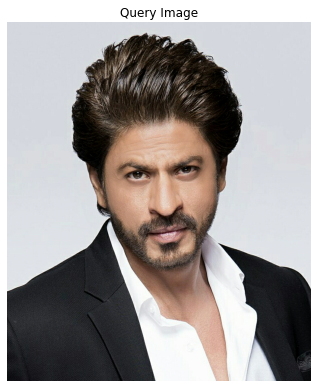

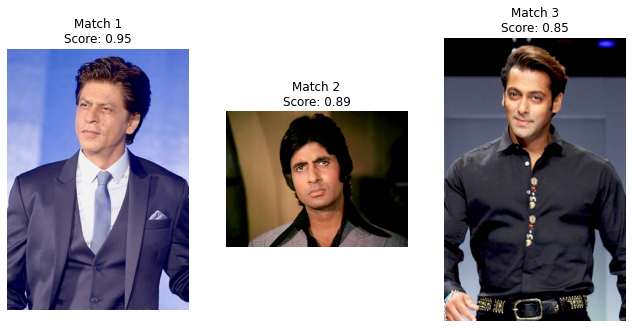

In [140]:
# After indexing, compare a query image
query_image_path = "./testing_dataset/1.jpg"  # Path to the query image
search_similar_faces(query_image_path)

C:\Users\Desktop\AppData\Local\Temp\ipykernel_13876\2074912643.py:25: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.search(index=INDEX_NAME, body=script, size=3)  # Retrieve top 3 similar images


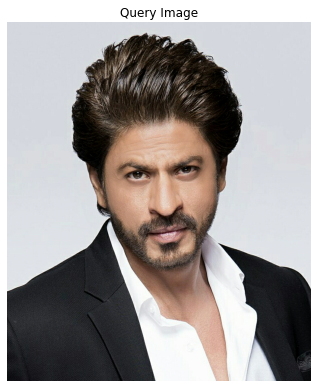

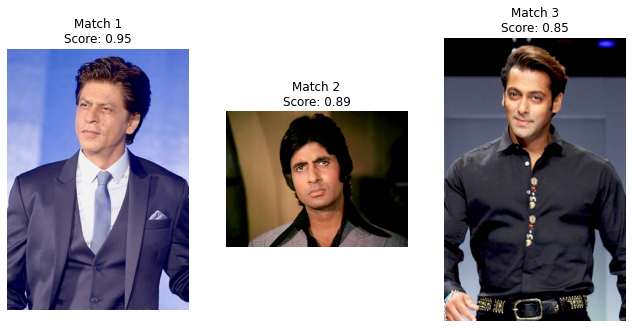

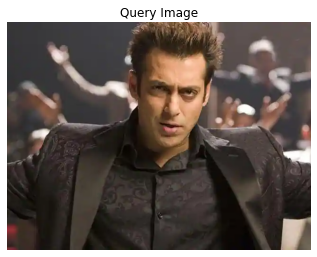

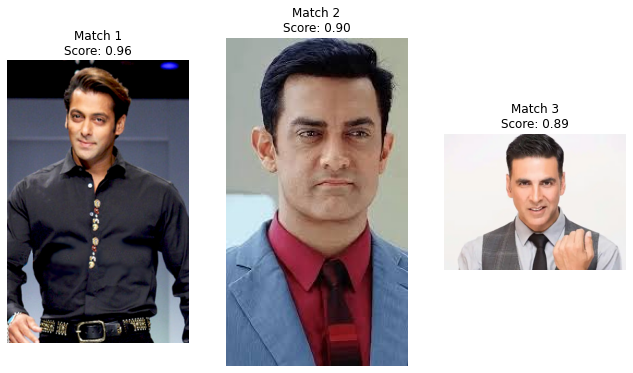

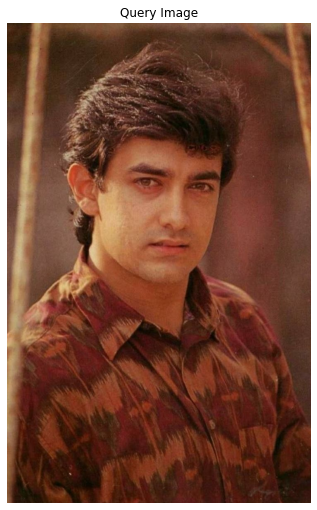

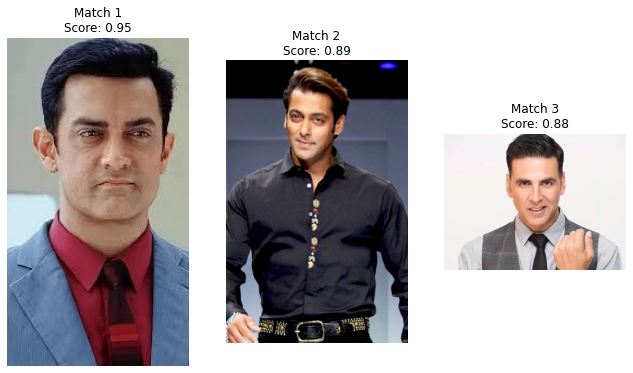

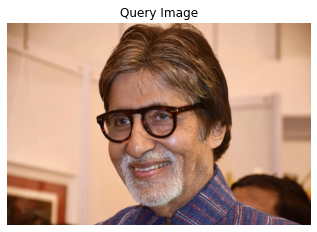

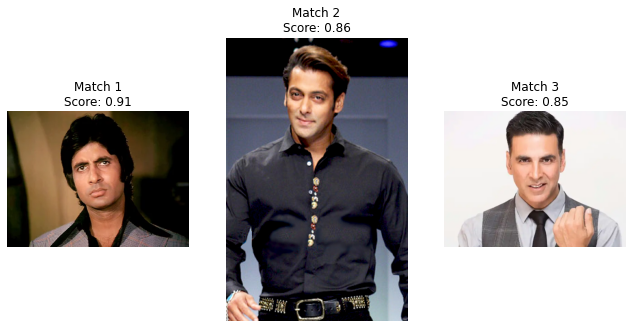

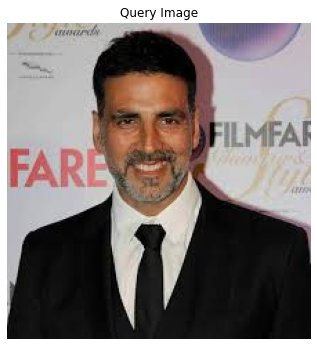

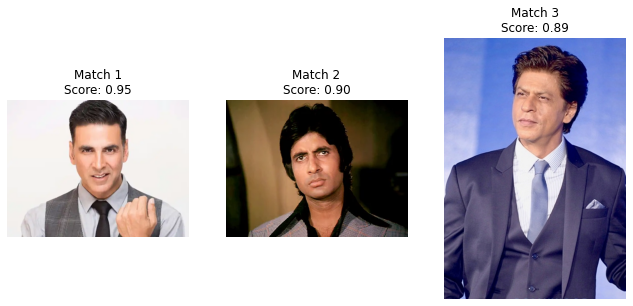

In [139]:
for query_image_path in glob.glob('testing_dataset/*'):
    search_similar_faces(query_image_path)